# Imports

In [1]:
import pickle
import random

from IPython.display import display, clear_output
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from torch.nn import Parameter
from torch_geometric.nn import HeteroConv, GATConv
from torch_geometric.nn.inits import glorot
import torch_geometric.transforms as T
import torch.nn as nn
from torch.optim import Adam
from torch.nn import MSELoss
from torch_geometric_temporal.signal import DynamicHeteroGraphTemporalSignal

from models import HeteroGCLSTM_GAT, HeteroGCGRU_GAT
from utils import extract_sequences_new_idea, plot_loss, predict_future_with_water, train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed()

In [4]:
with open('dataset.pkl', 'rb') as file:  # 'rb' - режим чтения в бинарном формате
    dataset = pickle.load(file)

# Create sequences

In [5]:
# Define sequence lengths
history_length = 30  # 30 days of historical data
prediction_length = 30  # Predict 1 days ahead

# Extract sequences and targets
sequences_new, target_sequences, targets_new = extract_sequences_new_idea(dataset, history_length, prediction_length)

In [6]:
len(sequences_new)

1887

# Meta

In [6]:
num_prod_feat = 1
num_inj_feat = 1

input_dims = {"prod": num_prod_feat, "inj": num_inj_feat}
meta = dataset[0].metadata()

# Model

In [7]:
class HeteroGCLSTMEncoder_new_GAT_one_step(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers):
        super(HeteroGCLSTMEncoder_new_GAT_one_step, self).__init__()
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_GAT(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])

    def forward(self, x_dict_seq, edge_index_dict_seq):
        h_dict = None
        c_dict = None
        for t in range(len(x_dict_seq)):
            x_dict = x_dict_seq[t]
            edge_index_dict = edge_index_dict_seq[t]
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(x_dict, edge_index_dict, h_dict, c_dict)
        return h_dict, c_dict, edge_index_dict_seq[-1]

class HeteroGCLSTMDecoder_new_GAT_one_step(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMDecoder_new_GAT_one_step, self).__init__()
        self.num_layers = num_layers
        self.output_node_type = output_node_type
        self.lstm_cells = nn.ModuleList([
            HeteroGCLSTM_GAT(in_channels_dict, out_channels, metadata) for _ in range(num_layers)
        ])
        self.inter_linear = nn.Linear(out_channels, 1)
        self.output_layer = nn.Linear(out_channels, 1)  # Assuming we predict a single feature

    def forward(self, x_dict_seq, edge_index_dict, h_dict, c_dict, future_steps):
        predictions = []

        tmp = self.inter_linear(h_dict[self.output_node_type])
        current_input = {"prod": tmp, "inj": x_dict_seq[0]["inj"]}
        current_edge_index = edge_index_dict

        for step in range(future_steps):
            for lstm_cell in self.lstm_cells:
                h_dict, c_dict = lstm_cell(current_input, current_edge_index, h_dict, c_dict)
            prediction = self.output_layer(h_dict[self.output_node_type])
            predictions.append(prediction)

        return predictions

class HeteroGCLSTMSeq2Seq_new_GAT_one_step(nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, num_layers, output_node_type):
        super(HeteroGCLSTMSeq2Seq_new_GAT_one_step, self).__init__()
        self.encoder = HeteroGCLSTMEncoder_new_GAT_one_step(in_channels_dict, out_channels, metadata, num_layers)
        self.decoder = HeteroGCLSTMDecoder_new_GAT_one_step(in_channels_dict, out_channels, metadata, num_layers, output_node_type)

    def forward(self, x_dict_seq, edge_index_dict_seq, x_dict_seq_target, future_steps):
        h_dict, c_dict, edge_index_dict = self.encoder(x_dict_seq, edge_index_dict_seq)
        predictions = self.decoder(x_dict_seq_target, edge_index_dict, h_dict, c_dict, future_steps)
        return torch.stack(predictions, dim=1).squeeze(dim=2)

In [22]:
model_seq2seq_gat_one_step = HeteroGCLSTMSeq2Seq_new_GAT_one_step(
    in_channels_dict=input_dims,
    out_channels=8,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

# Train/test splitting

In [8]:
train_sequences_new, test_sequences_new, train_targets_new, test_targets_new, train_target_sequences, test_target_sequences = train_test_split(sequences_new, targets_new, target_sequences, train_ratio=0.8)

In [10]:
len(train_sequences_new), len(train_targets_new), len(train_target_sequences)

(1509, 1509, 1509)

# Model training

In [ ]:
# torch.autograd.set_detect_anomaly(True)

In [25]:
model_seq2seq_gat_one_step.to(device, non_blocking=True)

# Define optimizer, and loss function
optimizer = Adam(model_seq2seq_gat_one_step.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Combine sequences and targets into a single list of tuples
train_data = list(zip(train_sequences_new, train_targets_new, train_target_sequences))
test_data = list(zip(test_sequences_new, test_targets_new, test_target_sequences))
accumulation_steps = 16

history = []
history_test = []

n_epochs = 40

# Training loop
for epoch in range(n_epochs):  # Number of epochs
    model_seq2seq_gat_one_step.train()
    
    train_loss = 0
    train_rmse = 0

    # Shuffle the training data at the start of each epoch
    random.shuffle(train_data)

    optimizer.zero_grad()
    
    # Iterate over the shuffled training data
    for i, (sequence, target, target_seq) in enumerate(train_data):

        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
        
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
        
        output = model_seq2seq_gat_one_step(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)

        loss = loss_fn(output, target[:, 0].unsqueeze(dim=1))
        train_loss += loss.item()
        train_rmse += torch.sqrt(loss).item()
        
        loss.backward()
        
        if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_data)):
            optimizer.step()
            optimizer.zero_grad()

    test_loss = 0
    test_rmse = 0
    model_seq2seq_gat_one_step.eval()
    for i, (sequence, target, target_seq) in enumerate(test_data):

        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
        
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
        
        output = model_seq2seq_gat_one_step(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)
        
        loss = loss_fn(output, target[:, 0].unsqueeze(dim=1))
        test_loss += loss.item()
        test_rmse += torch.sqrt(loss).item()
        
    average_train_loss = train_loss / len(train_data)
    average_test_loss = test_loss / len(test_data)
    average_train_rmse = train_rmse / len(train_data)
    average_test_rmse = test_rmse / len(test_data)
    history.append(average_train_loss)
    history_test.append(average_test_loss)
    print(
        f"Epoch {epoch + 1}, Avg. Train Loss: {average_train_loss}, Avg. Train RMSE: {average_train_rmse} || "
        f"Avg. Test Loss: {average_test_loss}, Avg. Test RMSE: {average_test_rmse}"
    )

Epoch 1, Avg. Train Loss: 0.3521662672291614, Avg. Train RMSE: 0.5830634915923504 || Avg. Test Loss: 0.5400883974063964, Avg. Test RMSE: 0.7319249690525116
Epoch 2, Avg. Train Loss: 0.3245682939492052, Avg. Train RMSE: 0.5586110157355163 || Avg. Test Loss: 0.5234245086315448, Avg. Test RMSE: 0.7205407633667901
Epoch 3, Avg. Train Loss: 0.29901878308132046, Avg. Train RMSE: 0.5348320891519032 || Avg. Test Loss: 0.5035641746861594, Avg. Test RMSE: 0.7067164598949371
Epoch 4, Avg. Train Loss: 0.2715495886482333, Avg. Train RMSE: 0.5079908952995829 || Avg. Test Loss: 0.48124657539778914, Avg. Test RMSE: 0.6908831066555448
Epoch 5, Avg. Train Loss: 0.24470692860904397, Avg. Train RMSE: 0.48057450830067444 || Avg. Test Loss: 0.45645706686708665, Avg. Test RMSE: 0.6729151228117565
Epoch 6, Avg. Train Loss: 0.21909893240169867, Avg. Train RMSE: 0.4532198324513167 || Avg. Test Loss: 0.43132678360219984, Avg. Test RMSE: 0.6542523946396257
Epoch 7, Avg. Train Loss: 0.19603199027651505, Avg. Train

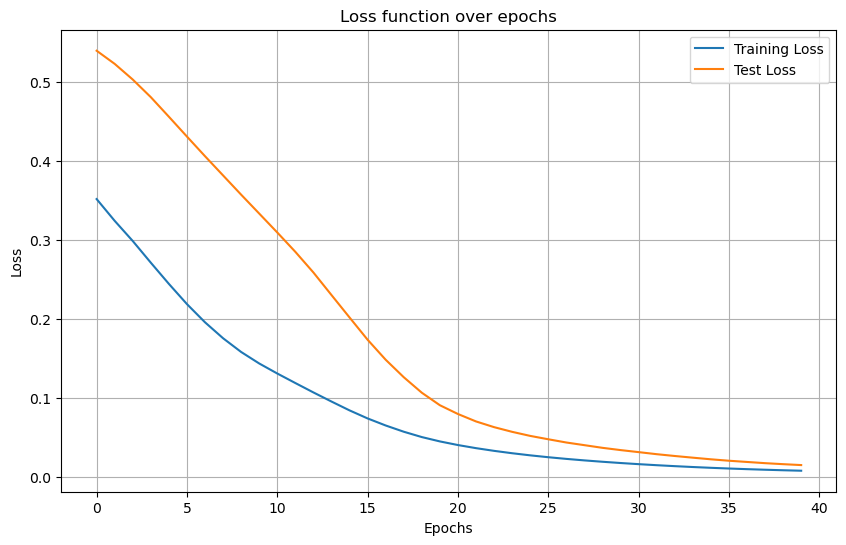

In [26]:
plot_loss(history, history_test)

# Save fitted model

In [27]:
torch.save(model_seq2seq_gat_one_step.state_dict(), 'fitted_models/model_seq2sew_gat_RN_one_step.pth')

# Load model and evaluate it

In [9]:
scaler_target = joblib.load("scaler_prod.save")
scaler_water = joblib.load("scaler_inj.save")

In [10]:
model_loaded = HeteroGCLSTMSeq2Seq_new_GAT_one_step(
    in_channels_dict=input_dims,
    out_channels=8,
    metadata=dataset[0].metadata(),
    num_layers=1,
    output_node_type="prod",
)

model_loaded.load_state_dict(torch.load('fitted_models/model_seq2sew_gat_RN_one_step.pth'))

<All keys matched successfully>

In [13]:
len(test_targets_new)

378

## Get prediction for 1 sample day

In [76]:
y_t = scaler_target.inverse_transform(test_targets_new[100][:, 0].unsqueeze(dim=1))

In [77]:
with torch.no_grad():
    sequence = [T.ToUndirected()(snapshot).to(device) for snapshot in test_sequences_new[100]]
    target_seq = [snapshot.to(device) for snapshot in test_target_sequences[100]]
        
    x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
    edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
    x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
        
    out = model_loaded(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)
    y_m = scaler_target.inverse_transform(out)

In [78]:
y_t, y_m = torch.tensor(y_t), torch.tensor(y_m)

In [81]:
absolute_percentage_errors = torch.abs((y_t + 1e-8 - y_m) / (y_t + 1e-8))

mape = torch.mean(absolute_percentage_errors) * 100

print(mape.item())

16.033671704137912


## Get prediction for 30 days

In [11]:
predictions = predict_future_with_water(model_loaded, test_sequences_new[0], test_target_sequences[0], steps=30)

In [12]:
y_t = scaler_target.inverse_transform(test_targets_new[0])
y_t.shape

(205, 30)

In [13]:
y_m = scaler_target.inverse_transform(predictions)
y_m.shape

(205, 30)

In [15]:
y_m[100]

array([64.99636762, 64.44554754, 63.99694409, 63.66402378, 63.40423813,
       63.20338641, 63.04732162, 62.91242362, 62.76964627, 62.63148909,
       62.4959285 , 62.36056491, 62.22457454, 62.08806486, 61.95053444,
       61.80999554, 61.6648902 , 61.51423351, 61.36305749, 61.21965338,
       61.07959799, 60.93540594, 60.78575207, 60.63160339, 60.47663097,
       60.30960672, 60.14118568, 59.97328396, 59.80758488, 59.64611199])

### Visualize predictions for first 10 wells

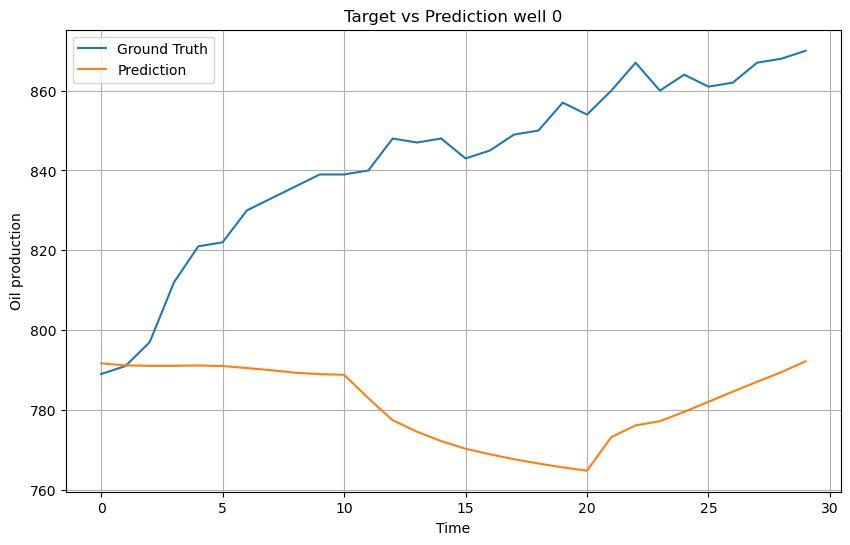

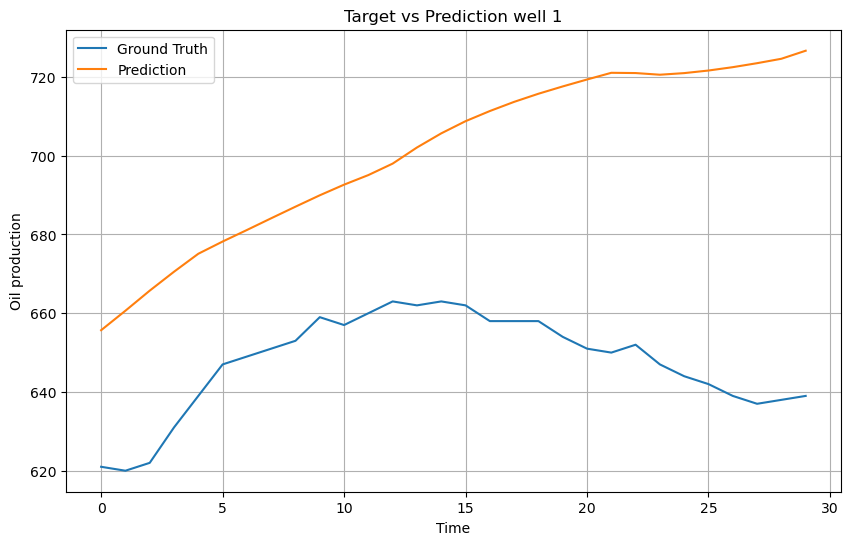

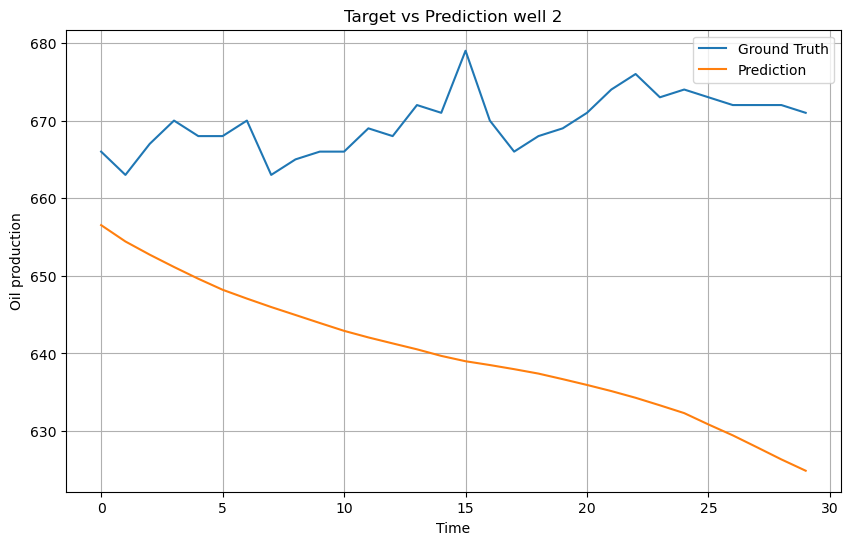

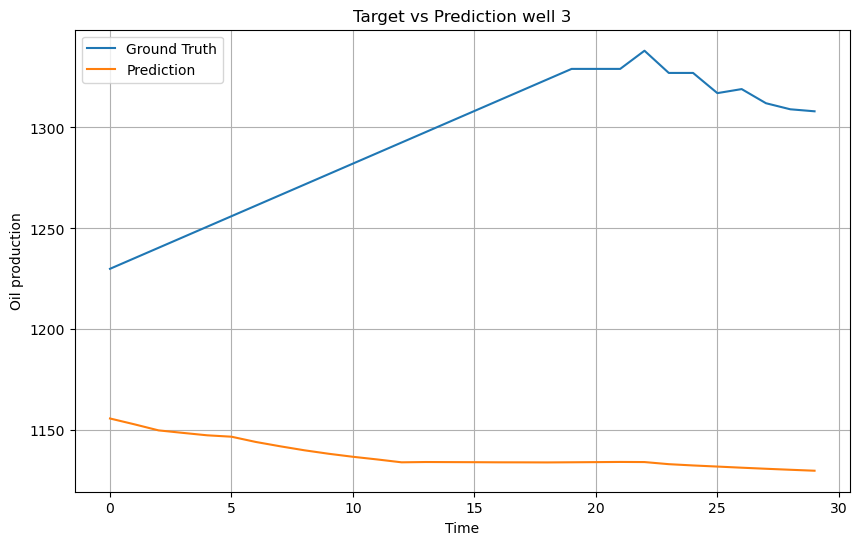

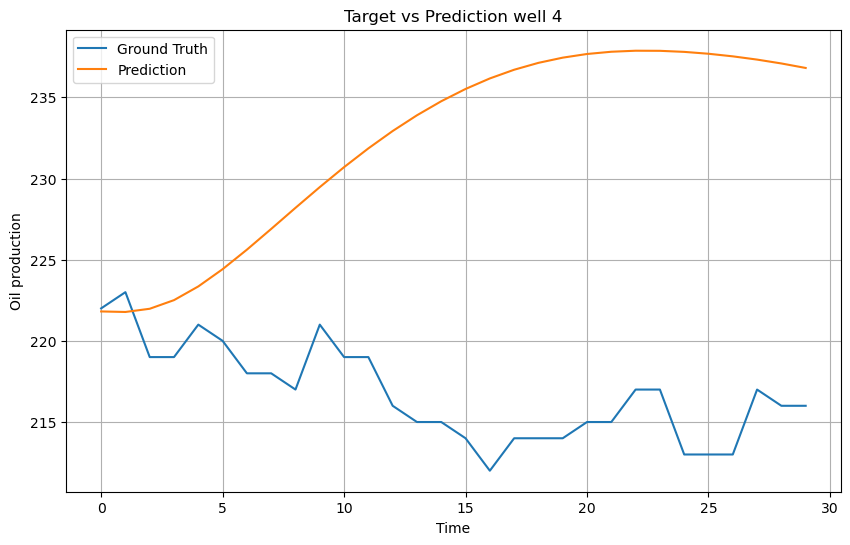

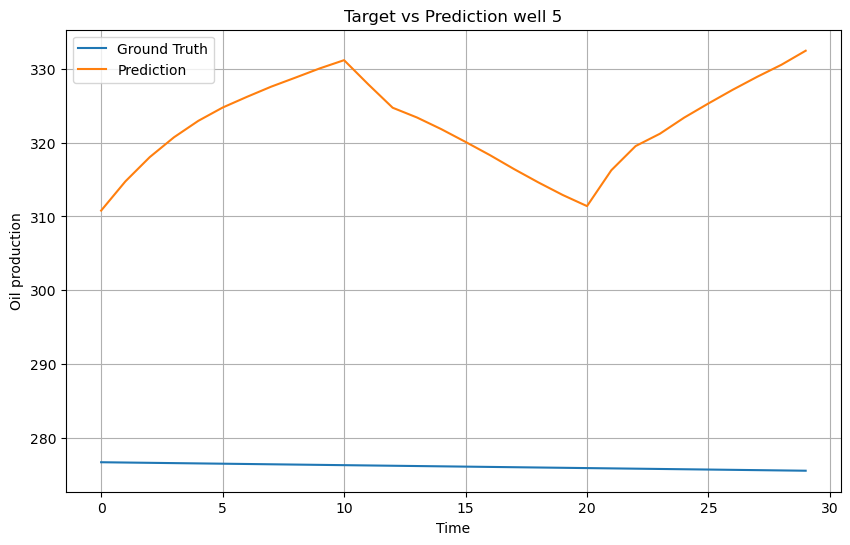

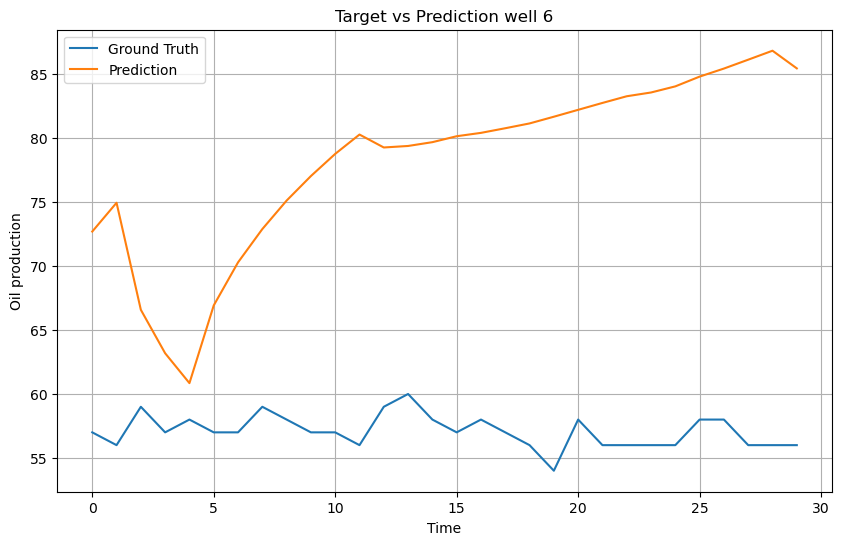

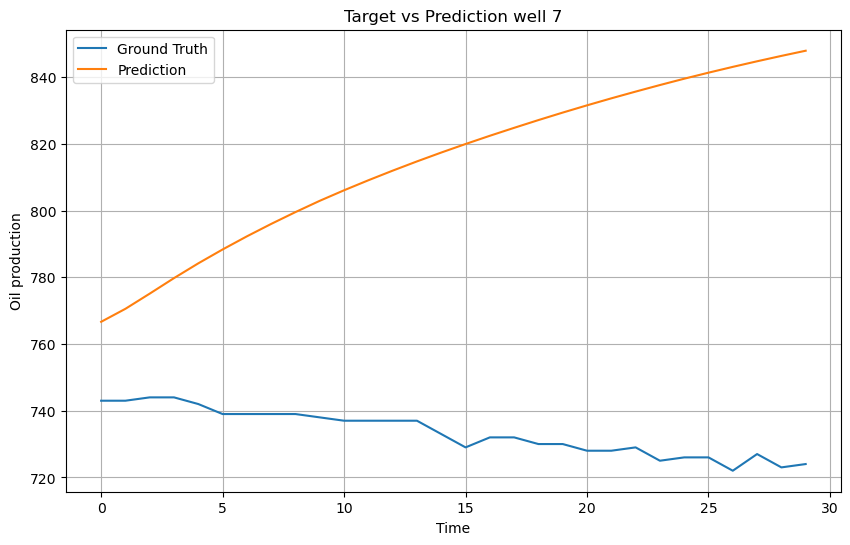

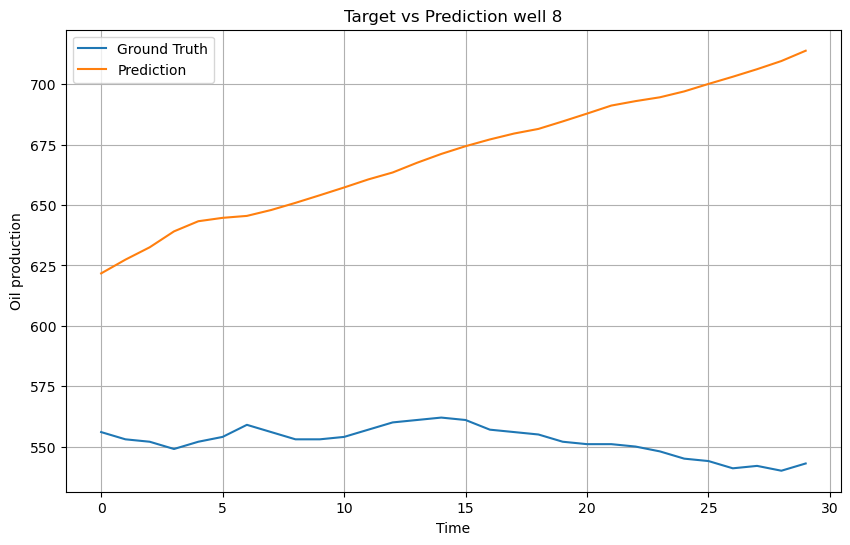

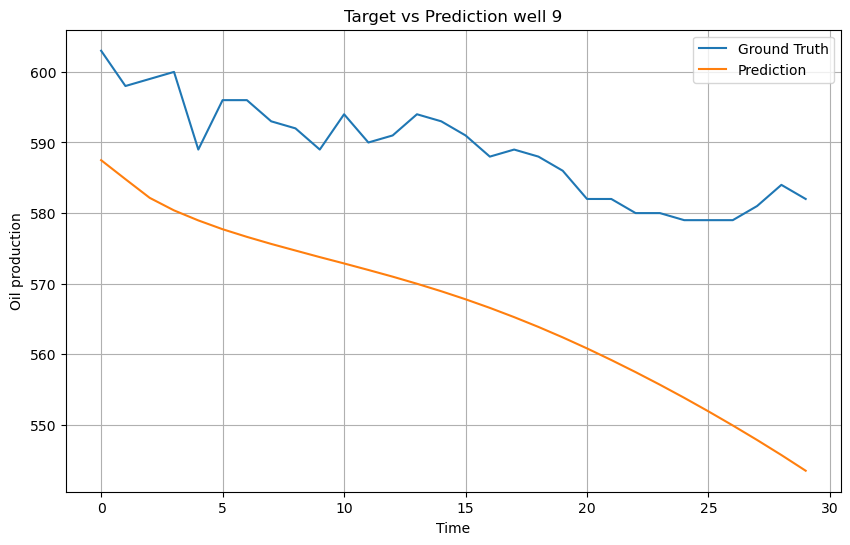

In [17]:
for i in range(10):
    plt.figure(figsize=(10, 6))
    plt.plot(y_t[i], label='Ground Truth')
    plt.plot(y_m[i], label='Prediction')
    plt.title(f'Target vs Prediction well {i}')
    plt.xlabel('Time')
    plt.ylabel('Oil production')
    plt.legend()
    plt.grid(True)
    plt.show()

## Calculate MAPE metric for test data

In [98]:
test_data = list(zip(test_sequences_new, test_targets_new, test_target_sequences))

test_mape = 0
with torch.no_grad():
    model_loaded.eval()
    for i, (sequence, target, target_seq) in enumerate(test_data):
    
        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
            
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
            
        output = model_loaded(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)
    
        y_t = scaler_target.inverse_transform(target[:, 0].unsqueeze(dim=1))
        y_m = scaler_target.inverse_transform(output)
        y_t, y_m = torch.tensor(y_t), torch.tensor(y_m)
        
        absolute_percentage_errors = torch.abs((y_t + 1e-8 - y_m) / (y_t + 1e-8))
        mape = torch.mean(absolute_percentage_errors) * 100
        test_mape += mape.item()

average_test_mape = test_mape / len(test_data)

In [99]:
print(f"Avg. MAPE on test data: {average_test_mape}%")

Avg. MAPE on test data: 18.86765434962796%


# Прогнозы с разными стратегиями

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
inj_wells = 9

In [26]:
# Параметры
inj_mean, inj_std = scaler_water.mean_, scaler_water.scale_


def generate_sequence(x_dict, increase=True):
    if increase:
        water_inj = torch.tensor(
            scaler_water.transform(np.random.normal(inj_mean + inj_std, 0, (inj_wells, 1))),
            dtype=torch.float
        )
    else:
        water_inj = torch.tensor(
            scaler_water.transform(np.random.normal(inj_mean - inj_std, 0, (inj_wells, 1))),
            dtype=torch.float
        )
    x_dict["inj"] = water_inj
    return x_dict


def predict_future_with_water_new(model, sequence, target_seq, steps=30, increase=True):
    """
    Рекуррентное предсказание на `steps` шагов вперед для гетерогенной модели.
    
    :param model: Обученная модель HeteroGCLSTMSeq2Seq_new_GAT_one_step.
    :param initial_history: Начальная история (список словарей x_dict_seq).
    :param edge_index_dict_seq: Последовательность словарей edge_index_dict.
    :param feature: Дополнительный признак (список словарей x_dict_seq_target).
    :param steps: Количество шагов предсказания.
    :return: Предсказанные значения (список тензоров).
    """
    model.eval()
    predictions = []
    
    sequence = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence]
    target_seq = [snapshot.to(device) for snapshot in target_seq]
    
    x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
    edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
    x_dict_sequence_target = [generate_sequence(snapshot.x_dict, increase) for snapshot in target_seq]

    with torch.no_grad():
        model.eval()
        for step in range(steps):
            # Предсказание на один шаг вперед
            next_step = model(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)
            predictions.append(next_step)
            
            # Сдвигаем историю на один шаг вперед
            x_dict_sequence_target = x_dict_sequence_target[1:]
            if step < (steps - 1):
                tmp = {"prod": next_step, "inj": x_dict_sequence_target[0]["inj"]}
                x_dict_sequence = x_dict_sequence[1:] + [tmp]
                edge_index_dict_sequence = edge_index_dict_sequence[1:] + [edge_index_dict_sequence[-1]]
            
    return torch.stack(predictions, dim=1).squeeze()

In [29]:
predictions = predict_future_with_water_new(model_loaded, test_sequences_new[0], test_target_sequences[0], steps=30, increase=False)

y_t_new = scaler_target.inverse_transform(test_targets_new[0])

y_m_new = scaler_target.inverse_transform(predictions)

print(y_t_new.shape, y_m_new.shape)

(205, 30) (205, 30)


In [30]:
y_m_new[0]

array([791.67434781, 784.79911621, 776.05572728, 770.44018836,
       765.29139331, 760.93955838, 757.18845202, 753.89821582,
       751.04295539, 748.50917232, 746.21327389, 744.18441369,
       742.39902531, 740.7477649 , 739.28460599, 737.94096245,
       736.71744314, 735.44399742, 734.23817082, 733.09380313,
       732.0221045 , 731.01053962, 730.08414331, 729.2304877 ,
       728.4444154 , 727.72682179, 727.11814224, 726.66432767,
       726.42658629, 726.53048622])

In [34]:
test_data = list(zip(test_sequences_new, test_targets_new, test_target_sequences))
prod_res = []

with torch.no_grad():
    model_loaded.eval()
    for i, (sequence, target, target_seq) in enumerate(test_data):
    
        sequence, target = [T.ToUndirected()(snapshot).to(device) for snapshot in sequence], target.to(device)
        target_seq = [snapshot.to(device) for snapshot in target_seq]
            
        x_dict_sequence = [snapshot.x_dict for snapshot in sequence]
        edge_index_dict_sequence = [snapshot.edge_index_dict for snapshot in sequence]
        x_dict_sequence_target = [snapshot.x_dict for snapshot in target_seq]
            
        output = model_loaded(x_dict_sequence, edge_index_dict_sequence, x_dict_sequence_target, 1)
    
        y_t = scaler_target.inverse_transform(target[:, 0].unsqueeze(dim=1))
        y_m = scaler_target.inverse_transform(output)
        # y_t, y_m = torch.tensor(y_t), torch.tensor(y_m)

        prod_res.append(y_m)

In [35]:
gnn_lstm_1_for_test = np.squeeze(np.array(prod_res).T)

In [36]:
with open('gnn_lstm_1_for_test.pkl', 'wb') as file:
    pickle.dump(gnn_lstm_1_for_test, file)